<a href="https://colab.research.google.com/github/Pilo1961/QuestionAnswer_System/blob/master/code/SentenceEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook setup

In [93]:
import numpy as np
import pandas as pd
import json
from random import randint
import torch
import pickle

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
#usa cuda si esta disponible
cuda=torch.cuda.is_available()
use_cuda = cuda
print("Use cuda: ",cuda)

Use cuda:  True


In [95]:
# mount drive to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Leer dataset

In [0]:
#load data from pickle
path= "/content/drive/My Drive/QA/df_train.pkl"
with open(path, "rb") as p:
    df = pickle.load(p)

df.rename(columns={'paragraph.context':'context','paragraph.qas.question':'question','paragraph.qas.id':'id'},inplace=True)

In [97]:
print(df.shape)
df.head()

(87636, 6)


,answer_start,text,title,context,question,id
0,515,Saint Bernadette Soubirous,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,5733be284776f41900661182
1,187,a copper statue of Christ,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,5733be284776f4190066117f
2,279,the Main Building,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,5733be284776f41900661180
3,381,a Marian place of prayer and reflection,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,5733be284776f41900661181
4,92,a golden statue of the Virgin Mary,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,5733be284776f4190066117e


In [0]:
#load data from pickle
path= "/content/drive/My Drive/QA/df_test.pkl"
with open(path, "rb") as p:
    df_test = pickle.load(p)

df_test.rename(columns={'paragraph.context':'context','paragraph.qas.question':'question','paragraph.qas.id':'id'},inplace=True)

In [99]:
df_test.head()

,answer_start,text,title,context,question,id
0,176,Denver Broncos,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,56be4db0acb8001400a502ec
1,177,Denver Broncos,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,56be4db0acb8001400a502ec
2,177,Denver Broncos,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,56be4db0acb8001400a502ec
3,248,Carolina Panthers,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,56be4db0acb8001400a502ed
4,249,Carolina Panthers,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,56be4db0acb8001400a502ed


## Infersent 

Usamos el embedding preentrenado de InferSent. El modelo se entreno con GLoVE

In [100]:
#importa el modulo models de infersent
import sys
sys.path.append('/content/drive/My Drive/QA/')
from models import InferSent

model_version = 1
MODEL_PATH = "/content/drive/My Drive/QA/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [0]:
# Keep it on CPU or put it on GPU
model = model.cuda() if use_cuda else model

In [0]:
# Importa el embedding word2Vec GLovE preentrnado
W2V_PATH = '/content/drive/My Drive/QA/glove.840B.300d.txt' if model_version == 1 else 'fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

### Embedding de contextos

In [103]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Datos de entrenamiento

Tokenizamos los datos de entrenamiento

In [0]:
# Tokeniza datos test
#Hace cada oracion un token
#Convierte todo el texto a minusculas
contextos=df['context'].unique()
data=[]
for cont in contextos: # para cada contexto
  sample=cont
  for sent in sent_tokenize(sample): #Extrae las oraciones
    data.append(sent.lower())

In [105]:
#Hay 93576 oraciones en el train, cada una es un token en la lista data
print(len(data))
data[:5]

93576


['architecturally, the school has a catholic character.',
 "atop the main building's gold dome is a golden statue of the virgin mary.",
 'immediately in front of the main building and facing it, is a copper statue of christ with arms upraised with the legend "venite ad me omnes".',
 'next to the main building is the basilica of the sacred heart.',
 'immediately behind the basilica is the grotto, a marian place of prayer and reflection.']

#### Datos de prueba
Tokenizamos los datos de prueba
No usamos para calcular el vocabularion

In [0]:
# Tokeniza datos train
#Hace cada oracion un token
#Convierte todo el texto a minusculas
contextos=df_test['context'].unique()
data2=[]
for cont in contextos: # para cada contexto
  sample=cont
  for sent in sent_tokenize(sample): #Extrae las oraciones
    data2.append(sent.lower())

In [107]:
#Hay 10458 oraciones en el test, cada una es un token en la lista data
print(len(data2))
data2[:5]

10458


['super bowl 50 was an american football game to determine the champion of the national football league (nfl) for the 2015 season.',
 'the american football conference (afc) champion denver broncos defeated the national football conference (nfc) champion carolina panthers 24–10 to earn their third super bowl title.',
 "the game was played on february 7, 2016, at levi's stadium in the san francisco bay area at santa clara, california.",
 'as this was the 50th super bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each super bowl game with roman numerals (under which the game would have been known as "super bowl l"), so that the logo could prominently feature the arabic numerals 50.',
 'the panthers finished the regular season with a 15–1 record, and quarterback cam newton was named the nfl most valuable player (mvp).']

#### Vocabulario 
Caluclamos el vocabulario solamente usando los datos de entrenamiento.

In [108]:
# Construimos el vocabulario con las palabras en las oraciones
model.build_vocab(data,tokenize=False)

Found 59547(/168972) words with w2v vectors
Vocab size : 59547


In [109]:
#hacemos el encoding
embeddings = model.encode(data, bsize=128, tokenize=True, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings)))

Nb words kept : 2628013/2722521 (96.5%)
Speed : 1740.7 sentences/s (gpu mode, bsize=128)
nb sentences encoded : 93576


In [110]:
# dimensiones del embedding
embeddings.shape

(93576, 4096)

In [0]:
#diccionario con los embeddings
dict_context_embedding=dict(zip(data,embeddings))

In [0]:
import pickle
with open("/content/drive/My Drive/QA/context_embedding.pickle", 'wb') as handle:
    pickle.dump(dict_context_embedding, handle)

### Embedding de preguntas

In [0]:
questions=list(df['question'])
q_tokens=[]
for q in questions: # para ca
  #qq=sent_tokenize(q) #Extrae las oraciones
  q_tokens.append(sent_tokenize(q.lower()))

In [114]:
len(q_tokens)

87636

In [115]:
#hacemos el encoding
q_embeddings = model.encode(questions, bsize=128, tokenize=True, verbose=True)

Nb words kept : 863173/1164313 (74.1%)
Speed : 3374.0 sentences/s (gpu mode, bsize=128)


In [116]:
# dimensiones del embedding
print(q_embeddings.shape)
print(len(questions))

(87636, 4096)
87636


In [0]:
import pickle
with open("/content/drive/My Drive/QA/question-embedding.pickle", 'wb') as handle:
    pickle.dump(q_embeddings, handle)

## Distancia entre oraciones

In [0]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [119]:
print("Distancias Coseno")
print("Pregunta:")
print(questions[0])
for i in range(10):
  print(i)
  print(data[i])
  print(cosine(embeddings[i], q_embeddings[0]))

Distancias Coseno
Pregunta:
To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
0
architecturally, the school has a catholic character.
0.48496497
1
atop the main building's gold dome is a golden statue of the virgin mary.
0.4393835
2
immediately in front of the main building and facing it, is a copper statue of christ with arms upraised with the legend "venite ad me omnes".
0.50830585
3
next to the main building is the basilica of the sacred heart.
0.46015966
4
immediately behind the basilica is the grotto, a marian place of prayer and reflection.
0.4889662
5
it is a replica of the grotto at lourdes, france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858.
0.6117157
6
at the end of the main drive (and in a direct line that connects through 3 statues and the gold dome), is a simple, modern stone statue of mary.
0.48410287
7
as at most other universities, notre dame's students run a number of news media outlets.
0.49329674
8
the nine stu

### Visualizacion de vector

Importancia de palabras dentro de la oracion.

In [120]:
df['context'][0]

'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.'

In [121]:
df['question'][0]

'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?'

In [122]:
df['text'][0]

'Saint Bernadette Soubirous'

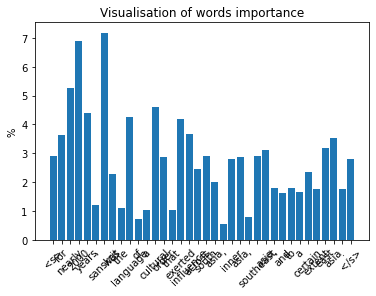

In [123]:
idx = randint(1, len(data))
_, _ = model.visualize(data[idx])


8 # Modelos


In [0]:
import pickle
with open("/content/drive/My Drive/QA/q-embedding.pickle", "rb") as f:
    q_dict = pickle.load(f)

with open("/content/drive/My Drive/QA/embedding.pickle", "rb") as p:
    s_dict = pickle.load(p)